# Финальный проект. Вариант 2

In [978]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
import pandahouse as ph
from random import random, randrange
import datetime
import numpy as np
from urllib.parse import urlencode
import requests

## Задание 1. A/B–тестирование

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена **новая механика оплаты услуг на сайте**, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

Вопросы:

*	На какие метрики Вы смотрите в ходе анализа и почему?
*	Имеются ли различия в показателях и с чем они могут быть связаны?
*	Являются ли эти различия статистически значимыми?
*	Стоит ли запускать новую механику на всех пользователей?ей?


### 1.1 Данные

*	groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
*	groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
*	active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
*	checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

### 1.2 EDA

* Датафрейм `groups_full` - принадлежность пользователей к группе

Так как данные о принадлежности пользователей к группам находятся в двух разных файлах, сначала нужно объединить эти данные в один датафрейм.

In [13]:
groups = pd.read_csv('Проект_2_groups.csv', sep = ';')
groups_add = pd.read_csv('Проект_2_group_add.csv', sep = ',')

In [15]:
groups_full = pd.concat([groups,groups_add], axis = 0)
groups_full.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


Проверка, что в объединенном датасете присутствуют все пользователи.

In [14]:
groups.shape[0] + groups_add.shape[0]

74576

In [16]:
groups_full.shape[0]

74576

* Датафрейм `active_users` - информация об активности пользователей в дни проведения эксперимента:

In [18]:
active_users = pd.read_csv('Проект_2_active_studs.csv')

In [19]:
active_users.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


Всего 8341 пользователей, активных в период эксперимента, это 11% от всех пользователей, распределенных по группам для эксперимента.

In [377]:
round(active_users.shape[0] / groups_full.shape[0] * 100, 2)

11.18

In [20]:
active_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


* Датафрейм `checks` - информация об оплатах пользователей в дни проведения экспериментов

In [22]:
checks = pd.read_csv('Проект_2_checks.csv', sep = ';')
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [24]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [25]:
checks.rev.describe()

count     541.000000
mean     1059.752317
std       762.712359
min       199.000000
25%       290.000000
50%       840.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

* Итоги EDA, объединение данных

Для эксперимента понадобятся данные об активных и платящих пользователей, сначала соединим информацию об активности пользователей с их группами.

Не учитываются пользователи, которые не были активными, но производили оплаты, т.к. влияние эксперимента на них оценить не удастся.

In [412]:
users_info = pd.merge(left = groups_full, right = active_users, left_on = 'id', right_on = 'student_id').drop(columns='student_id')
users_info.head()

,id,grp
0,1627,A
1,2085,B
2,2215,B
3,3391,A
4,3401,B


Количество человек в контрольной и тестовой группе сильно различаются, большая группа может давать более стабильный результат и вносить несправедливость в эксперимент при применении классического t-test, для достоверности сравнения лучше применить Bootstrap.

In [414]:
users_info.grp.value_counts()

grp
B    6803
A    1538
Name: count, dtype: int64

Теперь присоединим информацию об оплатах, колонка `is_purchase` необходима для расчета CR - значение 1 указывает на то, что пользователь совершил оплату во время эксперимента.

In [416]:
users_info = users_info.merge(checks, left_on = 'id', right_on = 'student_id', how = 'left').drop(columns='student_id').fillna(0)
users_info['is_purchase'] = (users_info.rev != 0).astype(int)
users_info.head()

,id,grp,rev,is_purchase
0,1627,A,990.0,1
1,2085,B,0.0,0
2,2215,B,0.0,0
3,3391,A,0.0,0
4,3401,B,0.0,0


95% активных пользователей не производили оплату в период эксперимента.

In [401]:
round(len(users_info.query('rev == 0')) / len(users_info) * 100,2)

95.3

### 1.3 Выбор метрик

**Изменение:** новая механика оплаты услуг на сайте <br>
**Доступная информация:** сумма покупок каждого пользователя и факт активности пользователей в период эксперимента

Исходя из доступной информации можно выбрать три метрики для измерения результата эксперимента:

1. `CR` - конверсия из активности в покупку
2. `ARPU` - средний доход на пользователя
3. `ARPPU` - средний поход на платящего пользователя

### 1.4 Функции для подсчета метрик

In [563]:
''' Функция подсчета значения CR для данных по одной группе '''
def calc_cr(group_data):
    return group_data.is_purchase.sum() / group_data.shape[0]

In [517]:
''' Функция подсчета значения ARPU для данных по одной группе '''
def calc_arpu(group_data):
    return group_data.rev.sum() / group_data.shape[0]
    

In [519]:
''' Функция подсчета значения ARPPU для данных по одной группе '''
def calc_arppu(group_data):
    return group_data.rev.sum() / group_data.query('is_purchase == 1').shape[0]

In [561]:
''' 
Функция подсчета значений определенной метрики по группе

Входные параметры: датасет с атрибутами [id, grp, rev, is_purchase], название метрики

Возвращает словарь с ключами:
metric_control - значение метрики в контрольной группе
metric_test - значение метрики в тестовой группе
metric_diff - разница между значением метрики в тестовой и контрольных группах
metric_diff_perc - разница между значением метрики в тестовой и контрольных группах в процентах
'''
def calculate_metric(users_data, metric):
    group_control = users_data[users_data.grp == 'A']
    group_test = users_data[users_data.grp == 'B']
    func_dict = {
        'cr' : calc_cr,
        'arpu' : calc_arpu,
        'arppu' : calc_arppu
    }
    if metric.lower() not in func_dict.keys():
        raise KeyError(f"Для данной метрики нет функции подсчета. Используйте метрики из списка: {func_dict.keys()}")
        
    metric_control = round(func_dict[metric.lower()](group_control),4)
    metric_test = round(func_dict[metric.lower()](group_test),4)
    metric_difference = round(metric_test - metric_control,2)
    metric_difference_perc = round((metric_test - metric_control) / metric_test * 100,2)
    metric_dict = {f'{metric}_control' : metric_control,
               f'{metric}_test' : metric_test,
               f'{metric}_diff' : metric_difference,
               f'{metric}_diff_perc' : metric_difference_perc}
    return metric_dict

### 1.4 Конверсия в покупку

Конверсия = отношение числа покупок к числу пользователей

Выделим информацию о пользователях каждой группы и подсчитаем для них CR

In [565]:
cr_groups = calculate_metric(users_info, 'cr')

Конверсия в покупку в тестовой группе уменьшилась на 9.74%, необходимо проверить данный результат на статистическую значимость

In [567]:
print(f"Конверсия в контрольной группе: {cr_groups['cr_control']}")
print(f"Конверсия в тестовой группе: {cr_groups['cr_test']}")
print(f"Разница по сравнению с контрольной группой: {cr_groups['cr_diff_perc']}%")

Конверсия в контрольной группе: 0.0507
Конверсия в тестовой группе: 0.0462
Разница по сравнению с контрольной группой: -9.74%


**Гипотеза H0**: Конверсия в покупку в тестовой группе не отличается от конверсии в контрольной

**Гипотеза H1**: Конверсия в покупку в тестовой группе отличается.

**Уровень значимости** : 0.05

In [569]:
pg.chi2_independence(users_info, 'is_purchase','grp')

(grp                    A            B
 is_purchase                          
 0            1465.718979  6483.281021
 1              72.281021   319.718979,
 grp               A       B
 is_purchase                
 0            1460.5  6488.5
 1              77.5   314.5,
                  test    lambda      chi2  dof      pval    cramer     power
 0             pearson  1.000000  0.484808  1.0  0.486252  0.007624  0.107123
 1        cressie-read  0.666667  0.482018  1.0  0.487510  0.007602  0.106787
 2      log-likelihood  0.000000  0.476541  1.0  0.489993  0.007559  0.106127
 3       freeman-tukey -0.500000  0.472522  1.0  0.491829  0.007527  0.105643
 4  mod-log-likelihood -1.000000  0.468578  1.0  0.493642  0.007495  0.105168
 5              neyman -2.000000  0.460909  1.0  0.497200  0.007434  0.104245)

Статистические тесты показали pval выше заданного уровня значимости (0.05), в данном эксперименте мы не можем отвергнуть нулевую гипотезу. 

**Вывод**: статистически значимых различий между конверсиями в покупку между группами не найдено.

### 1.5 ARPU

ARPU - средний доход на привлеченного пользователя. Отношение суммы дохода к количеству пользователей.

Отберем данные о пользователях каждой группы и посчитаем ARPU для контрольной и тестовых групп

In [571]:
arpu_groups = calculate_metric(users_info, 'arpu')

Средний доход на привлеченного пользователя в тестовой группе вырос на 10.7 руб., необходимо проверить результат на статистическую значимость.

In [573]:
print(f"ARPU в контрольной группе: {arpu_groups['arpu_control']}")
print(f"ARPU в тестовой группе: {arpu_groups['arpu_test']}")
print(f"Разница по сравнению с контрольной группой: {arpu_groups['arpu_diff']}")

ARPU в контрольной группе: 47.3472
ARPU в тестовой группе: 58.0588
Разница по сравнению с контрольной группой: 10.71


Количество пользователей в группах A и B:

In [59]:
users_a.shape[0]

1538

In [60]:
users_b.shape[0]

6803

**Гипотеза H0**: ARPU в контрольной и тестовой группе не отличается

**Гипотеза H1**: ARPU в тестовой группе отличается.

**Доверительный интервал** : 0.95

Используем Bootstrap, сгенерируем 10000 выборок из пользователей тестовой и контрольной группы.

Для каждой выборки посчитаем ARPU и разницу между ARPU тестовой и контрольной выборки, в итоге получим 10000 значений разницы ARPU, если доверительный интервал будет включать в себя 0, то принимаем нулевую гипотезу.

In [63]:
arpu_diff = []
for _ in range (10_000):
    sample_a = users_a.sample(frac=1, replace = True)
    sample_b = users_b.sample(frac=1, replace = True)
    arpu_a = sample_a.rev.sum() / len(sample_a)
    arpu_b = sample_b.rev.sum() / len(sample_b)
    arpu_diff.append(arpu_b - arpu_a)
    

In [64]:
def calc_confidence_interval(data, confidence):
    sd = np.std(data)
    mean = np.mean(data)
    confidence_level = 1 - confidence # 0.95 -> 0.05
    right_bound = np.quantile(data, 1 - confidence_level / 2)
    left_bound = np.quantile(data, confidence_level / 2)
    print(f"95% доверительный интервал находится в границах от {left_bound} до {right_bound}")
    if right_bound * left_bound < 0:
        print("0 попал внуть доверительного интервала => принимаем нулевую гипотезу")
    else:
        print("0 не попал внутрь доверительного интервала => отвергаем нулевую гипотезу")

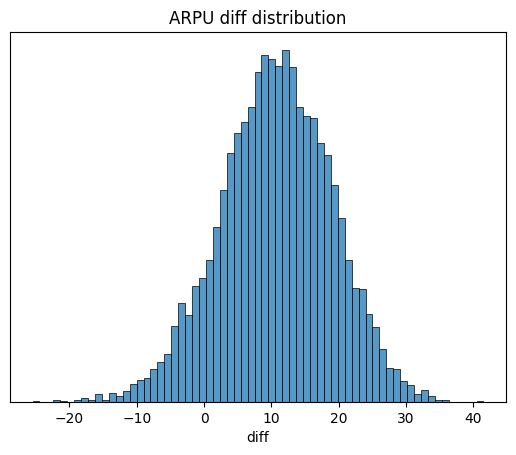

In [65]:
plt.title('ARPU diff distribution')
plt.xlabel("diff")
sns.histplot(arpu_diff)
ax = plt.gca()
ax.axes.yaxis.set_visible(False)


In [66]:
calc_confidence_interval(arpu_diff, 0.95)

95% доверительный интервал находится в границах от -6.046975388317354 до 26.31008090981576
0 попал внуть доверительного интервала => принимаем нулевую гипотезу


Различия между ARPU в тестовой и контрольной групе не значимы.

### 1.6 ARPPU

ARPPU - средний доход на платящего пользователя. Отношение суммы дохода к количеству платящих пользователей.

In [575]:
arppu_groups = calculate_metric(users_info,'arppu')

Средний доход на привлеченного платящего пользователя в тестовой группе вырос на 324 руб., необходимо проверить результат на статистическую значимость.

In [581]:
print(f"ARPPU в контрольной группе: {arppu_groups['arppu_control']}")
print(f"ARPPU в тестовой группе: {arppu_groups['arppu_test']}")
print(f"Разница по сравнению с контрольной группой: {arppu_groups['arppu_diff']}")

ARPPU в контрольной группе: 933.5897
ARPPU в тестовой группе: 1257.879
Разница по сравнению с контрольной группой: 324.29


**Гипотеза H0**: ARPPU в контрольной и тестовой группе не отличается

**Гипотеза H1**: ARPPU в тестовой группе отличается.

**Доверительный интервал** : 0.95

In [78]:
arppu_diff = []
for _ in range (10_000):
    sample_a = group_a.sample(frac=1, replace = True)
    sample_b = group_b.sample(frac=1, replace = True)
    arppu_a = sample_a.rev.sum() / len(sample_a)
    arppu_b = sample_b.rev.sum() / len(sample_b)
    arppu_diff.append(arppu_b - arppu_a)

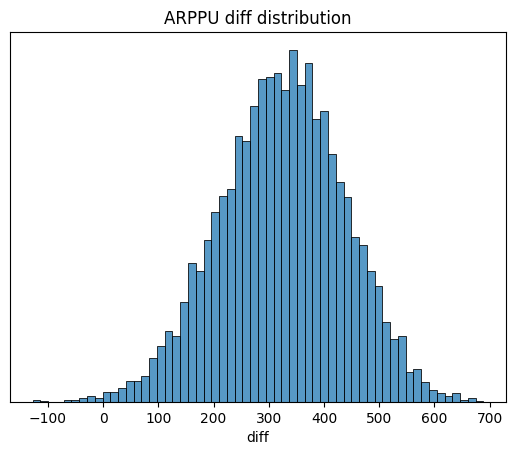

In [79]:
plt.title('ARPPU diff distribution')
plt.xlabel("diff")
sns.histplot(arppu_diff)
ax = plt.gca()
ax.axes.yaxis.set_visible(False)

In [80]:
calc_confidence_interval(arppu_diff, 0.95)

95% доверительный интервал находится в границах от 99.17596878838002 до 537.3785543248817
0 не попал внутрь доверительного интервала => отвергаем нулевую гипотезу


### 1.7 Выводы

1. Конверсия в покупку не изменилась
2. ARPU (средний доход на привлеченного пользователя) - не изменился
3. ARPPU (средний доход на платящего пользователя) - **статистически значимо увеличился**

Изменение повлияло в основном только на платящих пользователей, их сумма трат значимо увеличилась. Однако это могло быть связано с другими изменениями, произошедшими во время эксперимента, мало входных данных об эксперименте.

Я бы рекомендовала вводить данное изменение на всех пользователей, только если затраты на его внедрение в прод небольшие.

## Задание 2. SQL

### 2.1 Количество усердных учеников:


Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.


| Название атрибута | Тип атрибута | Смысловое значение                       |
|-------------------|--------------|------------------------------------------|
| st_id             | int          | ID ученика                               |
| timest            | timestamp    | Время решения карточки                   |
| correct           | bool         | Правильно ли решена горошина?            |
| subject           | text         | Дисциплина, в которой находится горошина |

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.

NB! Под очень усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

Текущим месяцем считать октябрь 2021 года.

In [88]:
connection= dict(database = 'default',
                  host = 'https://clickhouse.lab.karpov.courses',
                  user = 'student',
                  password = 'dpo_python_2020')

In [89]:
month = '2021-10'

In [90]:
query = f"""
SELECT COUNT (*) FROM 
    (SELECT
        st_id
    FROM peas
    WHERE toStartOfMonth(timest) == '{month}-01'
    GROUP BY st_id 
    HAVING sum(correct) > 20)
"""

In [91]:
count = ph.read_clickhouse(query,connection = connection)
count

,count()
0,130


### 2.2 Оптимизация воронки

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

Дана таблицы: default.peas (см. выше), default.studs:

| Название атрибута | Тип атрибута | Смысловое значение                  |
|-------------------|--------------|-------------------------------------|
| st_id             | int          | ID ученика                          |
| test_grp          | text         | Метка ученика в данном эксперименте |

default.final_project_check:

| Название атрибута | Тип атрибута | Смысловое значение                             |
|-------------------|--------------|------------------------------------------------|
| st_id             | int          | ID ученика                                     |
| sale_time         | timestamp    | Время покупки                                  |
| money             | int          | Цена, по которой приобрели данный курс         |
| subject           | text         | Дисциплина, на которую приобрели полный доступ |

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

*	`ARPU` - Average Revenue Per User, средний доход на привлеченного пользователя
*	`ARPAU` - Average Revenue Per Active User, средний доход на активного пользователя 
*	`CR` в покупку - Conversion Rate, отношение числа купивших курс пользователей к числу всех пользователей
*	`СR` активного пользователя в покупку - Conversion Rate, отношение числа купивших курс пользователей к числу активных пользователей
*	`CR` пользователя из активности по математике (subject = ’math’) в покупку курса по математике


ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах
.
Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.


* Распределение всех пользователей по группам

In [171]:
groups_count_query = """
SELECT test_grp, COUNT(distinct st_id) as count_st_id
FROM default.studs
GROUP BY test_grp
"""
groups_count = ph.read_clickhouse(groups_count_query,connection = connection)

In [159]:
groups_count

,test_grp,count_st_id
0,control,305
1,pilot,295


В эксперименте задействовано всего 600 пользователей, **305** в контрольной группе и **295** в тестовой

* Распределение активных пользователей по группам

In [173]:
groups_active_count_query = """
SELECT test_grp, COUNT(st_id)
FROM default.studs p LEFT JOIN default.final_project_check fc 
ON fc.st_id = p.st_id
WHERE st_id IN -- отбираем только активных пользователей
    (SELECT st_id
    FROM default.peas
    GROUP BY st_id
    HAVING SUM(correct) > 10)
GROUP BY test_grp
"""
groups_active_count = ph.read_clickhouse(groups_active_count_query,connection = connection)

In [175]:
groups_active_count

,test_grp,count(st_id)
0,control,130
1,pilot,106


Всего 236 активных пользователей, **130** в контрольной группе и **106** в тестовой

### План выполнения запроса

1. Получение ARPU и CR всех пользователей по группам


In [182]:
ARPU_CR_all_query = """
SELECT 
    test_grp, 
    SUM(money) / COUNT (st_id) as ARPU,
    COUNT(DISTINCT fc.st_id) / COUNT(DISTINCT st_id) as CR -- fc.st_id - купили курс, st_id - все пользователи
FROM default.studs p LEFT JOIN default.final_project_check fc 
ON fc.st_id = p.st_id
GROUP BY test_grp
"""
ARPU_CR_all = ph.read_clickhouse(ARPU_CR_all_query,connection = connection)

In [184]:
ARPU_CR_all

,test_grp,ARPU,CR
0,control,4496.753247,0.052459
1,pilot,11094.771242,0.111864


2. Получение ARPAU и CR активных пользователей

In [192]:
ARPU_CR_active_query = """
SELECT 
    test_grp,
    SUM(money) / COUNT (st_id) as ARPAU,
    COUNT(DISTINCT fc.st_id) / COUNT(DISTINCT st_id) as active_CR -- fc.st_id - купили курс, st_id - все пользователи
FROM default.studs p LEFT JOIN default.final_project_check fc 
ON fc.st_id = p.st_id
WHERE st_id IN -- отбираем только активных пользователей
    (SELECT st_id
    FROM default.peas
    GROUP BY st_id
    HAVING SUM(correct) > 10)
GROUP BY test_grp
"""
ARPU_CR_active = ph.read_clickhouse(ARPU_CR_active_query,connection = connection)

In [190]:
ARPU_CR_active

,test_grp,ARPAU,active_CR
0,control,10153.846154,0.118110
1,pilot,26933.962264,0.270833


3. Получение CR активных по математике пользователей

In [194]:
CR_math_query = """
SELECT 
    test_grp,
    COUNT(DISTINCT fc.st_id) / COUNT(DISTINCT st_id) as math_CR -- fc.st_id - купили курс, st_id - все пользователи
FROM default.studs p LEFT JOIN default.final_project_check fc 
ON fc.st_id = p.st_id
WHERE st_id IN -- отбираем только активных по математике пользователей
    (SELECT st_id
    FROM default.peas
    WHERE subject = 'Math'
    GROUP BY st_id
    HAVING SUM(correct) > 1)
GROUP BY test_grp
"""
CR_math = ph.read_clickhouse(CR_math_query,connection = connection)

In [196]:
CR_math

,test_grp,math_CR
0,control,0.122449
1,pilot,0.166667


4. Объединение всех метрик по группам

In [207]:
full_query = """
SELECT 
    all_users.test_grp as group,
    ARPU,
    CR,
    ARPAU,
    active_CR,
    math_CR
FROM
    -- ARPU и CR всех пользователей
    (SELECT 
        test_grp, 
        SUM(money) / COUNT (st_id) as ARPU,
        COUNT(DISTINCT fc.st_id) / COUNT(DISTINCT st_id) as CR -- fc.st_id - купили курс, st_id - все пользователи
    FROM default.studs p LEFT JOIN default.final_project_check fc 
    ON fc.st_id = p.st_id
    GROUP BY test_grp) all_users
JOIN 
    -- ARPAU и CR активных пользователей
    (SELECT 
        test_grp,
        SUM(money) / COUNT (st_id) as ARPAU,
        COUNT(DISTINCT fc.st_id) / COUNT(DISTINCT st_id) as active_CR -- fc.st_id - купили курс, st_id - все пользователи
    FROM default.studs p LEFT JOIN default.final_project_check fc 
    ON fc.st_id = p.st_id
    WHERE st_id IN -- отбираем только активных пользователей
        (SELECT st_id
        FROM default.peas
        GROUP BY st_id
        HAVING SUM(correct) > 10)
    GROUP BY test_grp
    ) active_users
ON all_users.test_grp = active_users.test_grp
JOIN
    -- CR активных по математике пользователей
    (SELECT 
        test_grp,
        COUNT(DISTINCT fc.st_id) / COUNT(DISTINCT st_id) as math_CR -- fc.st_id - купили курс, st_id - все пользователи
    FROM default.studs p LEFT JOIN default.final_project_check fc 
    ON fc.st_id = p.st_id
    WHERE st_id IN -- отбираем только активных по математике пользователей
        (SELECT st_id
        FROM default.peas
        WHERE subject = 'Math'
        GROUP BY st_id
        HAVING SUM(correct) > 1)
    GROUP BY test_grp
    ) math_users
ON all_users.test_grp = math_users.test_grp
"""
full_metrics = ph.read_clickhouse(full_query,connection = connection)

In [209]:
full_metrics

,group,ARPU,CR,ARPAU,active_CR,math_CR
0,control,4496.753247,0.052459,10153.846154,0.118110,0.122449
1,pilot,11094.771242,0.111864,26933.962264,0.270833,0.166667


## Задание 3. Python

### 3.1 Выгрузка дополнительной информации

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

Добавление данных будет происходить в тестовый существующий датафрейм `test_data`

In [599]:
test_data = pd.merge(left = groups, right = active_users, left_on = 'id', right_on = 'student_id').drop(columns='student_id')
test_data = test_data.merge(checks, left_on = 'id', right_on = 'student_id', how = 'left').drop(columns='student_id').fillna(0)
test_data['is_purchase'] = (test_data.rev != 0).astype(int)
test_data.head()

,id,grp,rev,is_purchase
0,1627,A,990.0,1
1,2085,B,0.0,0
2,2215,B,0.0,0
3,3391,A,0.0,0
4,3401,B,0.0,0


Новые данные будут выгружаться по публичной ссылке (`add_csv_link`) с Яндекс-диска через API

In [936]:
add_csv_link = 'https://disk.yandex.ru/d/P_Fm8Qjta2ntng'

In [934]:
metrics_list = ['cr','arpu','arppu'] # отслеживаемые метрики

In [1233]:
control_df = pd.DataFrame(columns = ['cr_control','cr_test','arpu_control','arpu_test','arppu_control','arppu_test','date']) # датафрейм для отслеживания метрик по дням

In [1235]:
control_df

,cr_control,cr_test,arpu_control,arpu_test,arppu_control,arppu_test,date


In [806]:
'''
Функция для получения датафрейма по ссылке Яндекс-диск
Принимает на вход ссылку на csv-файл (link) и разделитель в данном файле (sep)
Возвращает скачанный Pandas DataFrame
'''
def get_csv_from_yandex(link, sep = ','):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' # базовый URL для API 
    final_url = base_url + urlencode(dict(public_key=link)) # ссылка с параметрами для запроса на API яндекса
    try:
        response = requests.get(final_url)
        response.raise_for_status()
        download_url = response.json()['href']
        add_data = pd.read_csv(download_url, sep = sep)
        return add_data
    except requests.exceptions.RequestException as e:
        print(f"Ошибка при запросе для {link}\n{e}")
    except Exception as e:
        print(f"Ошибка при обработке {link}\n{e}")
    

In [930]:
'''
Функция для добавления информации о состоянии метрик на текущий день в датафрейм с динамикой метрик по дням
Принимает на вход:
- df: Pandas DataFrame с данными, по которым будут просчитываться метрики
(датафрейм должен удовлетворять структуре, указанной в функции calculate_metric)
- metric_list: Метрики, которые необходимо посчитать
- metric_df: Pandas DataFrame с данными о динамике метрик по дням, в него будут записаны данные о состоянии метрик на текущий день
''' 
def update_metrics_df(df, metrics_list, metrics_df):
    columns = []
    metric_values = []
    for metric in metrics_list:
        calc = calculate_metric(df,metric)
        for key, value in list(calc.items())[:2]:
            columns.append(key)
            metric_values.append(value)
    columns.append('date')
    metric_values.append(datetime.date.today())
    metrics_today_dict = dict(zip(columns,metric_values))
    metrics_df.loc[len(metrics_df)] = metrics_today_dict # добавление записи о состоянии метрик на текущий день
    metrics_df.drop_duplicates(subset='date', inplace = True) # удаление дубликатов по дате

In [932]:
'''
Функция для обновления данных эксперимента с помощью скачанных с Яндекс-диска данных
Принимает на вход:
- old data : Pandas DataFrame со старыми данными
- link ссылка на Яндекс-диск с новыми данными
- metric_df: Pandas DataFrame с данными о динамике метрик по дням
Возвращает обновленный Pandas DataFrame
'''
def update_data(old_data, update_link, metrics_df):
    add_groups = get_csv_from_yandex(update_link) # получение новых данных
    new_data = old_data.merge(add_groups, on = 'id', how = 'outer')
    new_data[['grp_x','grp_y']] = new_data[['grp_x','grp_y']].fillna('')
    new_data['grp'] = new_data.grp_x + new_data.grp_y
    new_data = new_data.drop(columns=['grp_x','grp_y']).fillna(0)
    update_metrics_df(new_data, metrics_list, metrics_df)
    return new_data

In [1237]:
test_updated_data = update_data(test_data, add_csv_link, control_df)

Проверка работы функции:

In [1239]:
test_data.shape[0]

8354

In [1241]:
test_updated_data.shape[0]

8433

In [1243]:
control_df

,cr_control,cr_test,arpu_control,arpu_test,arppu_control,arppu_test,date
0,0.0502,0.0457,46.8597,57.3579,933.5897,1255.8275,2025-02-15


### 3.2 Построение графиков по метрикам

Реализуйте функцию, которая будет строить графики по получаемым метрикам.

Для отслеживания динамики метрик на графиках добавим случайные данные в датафрейм с метриками по дням.

In [1245]:
def add_random_samples(control_df, n_samples):
    columns = ['cr_control','cr_test','arpu_control','arpu_test','arppu_control','arppu_test','date']
    for i in range (n_samples):
        metrics = []
        metrics.append(round(control_df.iloc[len(control_df) - 1,0] + random() / 50 - random() / 50,4))
        metrics.append(round(control_df.iloc[len(control_df) - 1,1] + random() / 50 - random() / 50,4))
        metrics.append(control_df.iloc[len(control_df) - 1,2] + randint(-10,10))
        metrics.append(control_df.iloc[len(control_df) - 1,3] + randint(-10,10))
        metrics.append(control_df.iloc[len(control_df) - 1,4] + randint(-50,50))
        metrics.append(control_df.iloc[len(control_df) - 1,5] + randint(-50,50))
        metrics.append(control_df.iloc[len(control_df) - 1, 6] + datetime.timedelta(1))
        sample_dict = dict(zip(columns,metrics))
        control_df.loc[len(control_df)] = sample_dict

In [1249]:
add_random_samples(control_df, 15)

In [1251]:
control_df.head()

,cr_control,cr_test,arpu_control,arpu_test,arppu_control,arppu_test,date
0,0.0502,0.0457,46.8597,57.3579,933.5897,1255.8275,2025-02-15
1,0.0488,0.0485,49.8597,66.3579,950.5897,1264.8275,2025-02-16
2,0.0490,0.0382,43.8597,71.3579,939.5897,1233.8275,2025-02-17
3,0.0436,0.0455,46.8597,71.3579,944.5897,1230.8275,2025-02-18
4,0.0385,0.0368,52.8597,77.3579,963.5897,1253.8275,2025-02-19


In [1397]:
'''
Функция для построения графиков динамики отслеживаемых метрик
Принимает на вход датафрейм со значениями метрик по дням
'''
def plot_metrics_dynamic(control_df):
    fig, axes = plt.subplots(3,1,figsize=(12,14))
    sns.lineplot(data = control_df, x = 'date', y = 'cr_control', label = 'control', ax = axes[0])
    sns.lineplot(data = control_df, x = 'date', y = 'cr_test', label = 'test', ax = axes[0])
    axes[0].legend()
    axes[0].set_ylabel('CR')
    axes[0].set_xlabel('')
    axes[0].set_title('Conversion Rate dynamic')
    
    sns.lineplot(data = control_df, x = 'date', y = 'arpu_control', label = 'control', ax = axes[1])
    sns.lineplot(data = control_df, x = 'date', y = 'arpu_test', label = 'test', ax = axes[1])
    axes[1].legend()
    axes[1].set_ylabel('ARPU')
    axes[1].set_xlabel('')
    axes[1].set_title('ARPU dynamic')
    
    sns.lineplot(data = control_df, x = 'date', y = 'arppu_control', label = 'control', ax = axes[2])
    sns.lineplot(data = control_df, x = 'date', y = 'arppu_test', label = 'test', ax = axes[2])
    axes[2].legend()
    axes[2].set_ylabel('ARPPU')
    axes[2].set_xlabel('')
    axes[2].set_title('ARPPU dynamic')
    plt.xticks(rotation=45, fontsize = 8)

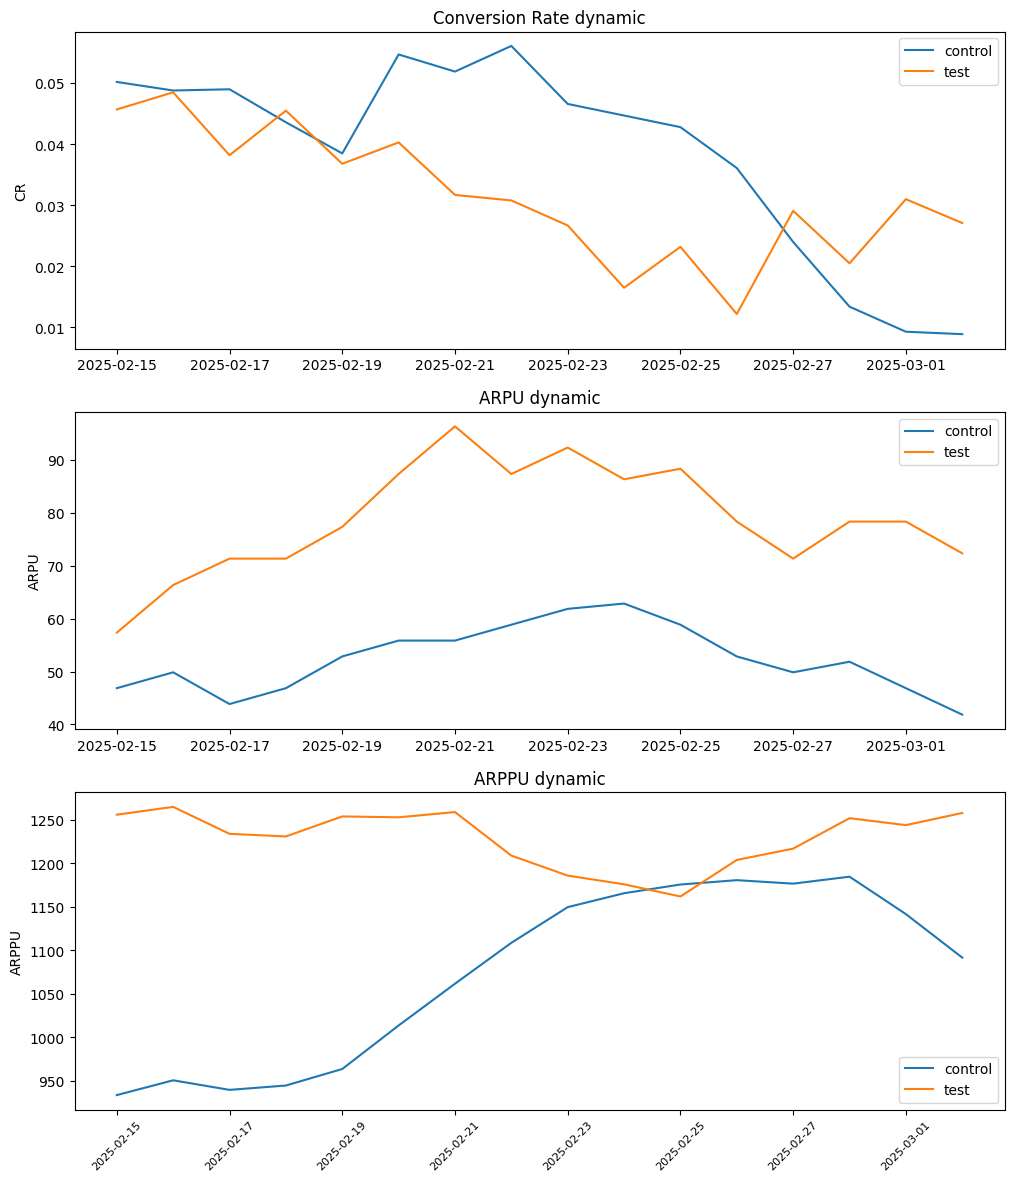

In [1399]:
plot_metrics_dynamic(control_df)